In [42]:
# imports
import pandas as pd
import numpy as np
import matplotlib.cm
from matplotlib import colors
import matplotlib.pyplot as plt

import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import sklearn.cluster as sklc  # For clustering
import sklearn.metrics as sklm  # For the silhouette score
from sklearn.preprocessing import RobustScaler

import statsmodels
import statsmodels.api as sm

# Read data

In [27]:
# read data into a DataFrame
df = pd.read_csv("data/need_2021_anon_dataset_50k.csv")

print(df.shape)

(50000, 75)


In [3]:
df.head()

,PROP_TYPE,PROP_AGE_BAND,FLOOR_AREA_BAND,CONSERVATORY_FLAG,COUNCIL_TAX_BAND,IMD_BAND_ENG,IMD_BAND_WALES,REGION,LI_FLAG,LI_DATE,...,ElecValFlag2014,ElecValFlag2013,ElecValFlag2012,ElecValFlag2011,ElecValFlag2010,ElecValFlag2009,ElecValFlag2008,ElecValFlag2007,ElecValFlag2006,ElecValFlag2005
0,Mid terrace,2,3,NaN,B,2.0,NaN,E12000005,0,NaN,...,V,E,E,V,E,V,V,V,V,V
1,Flat,3,2,NaN,A,1.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V
2,Mid terrace,1,3,NaN,A,2.0,NaN,E12000001,0,NaN,...,V,V,V,V,V,V,V,V,V,V
3,Flat,4,1,0.0,A,3.0,NaN,E12000004,0,NaN,...,O,O,O,O,O,O,O,O,O,O
4,Semi detached,2,2,NaN,D,5.0,NaN,E12000008,0,NaN,...,V,V,V,V,V,V,V,V,V,V


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PROP_TYPE          50000 non-null  object 
 1   PROP_AGE_BAND      50000 non-null  int64  
 2   FLOOR_AREA_BAND    50000 non-null  int64  
 3   CONSERVATORY_FLAG  7418 non-null   float64
 4   COUNCIL_TAX_BAND   50000 non-null  object 
 5   IMD_BAND_ENG       47410 non-null  float64
 6   IMD_BAND_WALES     2590 non-null   float64
 7   REGION             50000 non-null  object 
 8   LI_FLAG            50000 non-null  int64  
 9   LI_DATE            8568 non-null   float64
 10  CWI_FLAG           50000 non-null  int64  
 11  CWI_DATE           8412 non-null   float64
 12  PV_FLAG            50000 non-null  int64  
 13  PV_DATE            561 non-null    float64
 14  MAIN_HEAT_FUEL     50000 non-null  int64  
 15  Gcons2019          40329 non-null  float64
 16  Gcons2018          403

# Wrangle data
## select rows

In [28]:
# Select rows where the 'IMD_BAND_ENG' column is not NaN
df = df[df['IMD_BAND_ENG'].notna()]

print(df.shape)

(47410, 75)


## select columns

In [29]:
columns_of_interest = [
    'PROP_TYPE', 'PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND',
    'IMD_BAND_ENG', 'REGION', 'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
    'Gcons2019', 'Gcons2018', 'Gcons2017', 'Gcons2016', 'Gcons2015', 'Gcons2014', 'Gcons2013', 'Gcons2012', 'Gcons2011', 'Gcons2010', 'Gcons2009', 'Gcons2008', 'Gcons2007', 'Gcons2006', 'Gcons2005',
    'Econs2019', 'Econs2018', 'Econs2017', 'Econs2016', 'Econs2015', 'Econs2014', 'Econs2013', 'Econs2012', 'Econs2011', 'Econs2010', 'Econs2009', 'Econs2008', 'Econs2007', 'Econs2006', 'Econs2005'
]

df_filtered = df[columns_of_interest].copy()
print(df_filtered.shape)

(47410, 40)


## Handle outliers

In [7]:
numerical_cols = [f'Gcons{i}' for i in range(2019, 2004, -1)] + [f'Econs{i}' for i in range(2019, 2004, -1)]
for col in numerical_cols:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered.loc[df_filtered[col] < lower_bound, col] = lower_bound
    df_filtered.loc[df_filtered[col] > upper_bound, col] = upper_bound

## dealing with NaN

In [30]:
# Define the columns of interest
g_columns = [f'Gcons{i}' for i in range(2019, 2004, -1)]
e_columns = [f'Econs{i}' for i in range(2019, 2004, -1)]

# Drop rows where both Gcons and Econs columns are NaN
df_filtered = df_filtered.dropna(subset=g_columns + e_columns, how='all')

print(df_filtered.shape)
df_filtered.info()

(47335, 40)
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  object 
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         38309 non-null  float64
 11  Gcons2018         38318 non-null  float64
 12  Gcons2017         38206 non-null  float64
 13  Gcons2016         37731 non-null  float64
 14  Gcons2015         37236 non-null  float64
 15  Gcons2014         36954 non-null  float64
 16  Gcons2013         36639 non-null 

In [31]:
# fill NaN with 0 if both Gcons or Econs columns are NaN
condition1 = df_filtered.iloc[:, 10:25].isna().all(axis=1)
df_filtered.loc[condition1, df_filtered.columns[10:25]] = 0

condition2 = df_filtered.iloc[:, 25:].isna().all(axis=1)
df_filtered.loc[condition2, df_filtered.columns[25:]] = 0

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  object 
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         46100 non-null  float64
 11  Gcons2018         46109 non-null  float64
 12  Gcons2017         45997 non-null  float64
 13  Gcons2016         45522 non-null  float64
 14  Gcons2015         45027 non-null  float64
 15  Gcons2014         44745 non-null  float64
 16  Gcons2013         44430 non-null  float64
 17

In [32]:
# fill other NaN with the mean of the column
df_filtered.iloc[:, 10:] = df_filtered.iloc[:, 10:].apply(lambda col: col.fillna(col.mean()), axis=0)

df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  object 
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

## change data type

# Regression analysis

## One-hot encoding

In [33]:
df_filtered_numeric = pd.get_dummies(df_filtered, dtype=int)

df_filtered_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PROP_AGE_BAND            47335 non-null  int64  
 1   FLOOR_AREA_BAND          47335 non-null  int64  
 2   IMD_BAND_ENG             47335 non-null  float64
 3   LI_FLAG                  47335 non-null  int64  
 4   CWI_FLAG                 47335 non-null  int64  
 5   PV_FLAG                  47335 non-null  int64  
 6   MAIN_HEAT_FUEL           47335 non-null  int64  
 7   Gcons2019                47335 non-null  float64
 8   Gcons2018                47335 non-null  float64
 9   Gcons2017                47335 non-null  float64
 10  Gcons2016                47335 non-null  float64
 11  Gcons2015                47335 non-null  float64
 12  Gcons2014                47335 non-null  float64
 13  Gcons2013                47335 non-null  float64
 14  Gcons2012                47

## Checking the correlation between variables

Text(0.5, 1.0, 'Correlation Matrix')

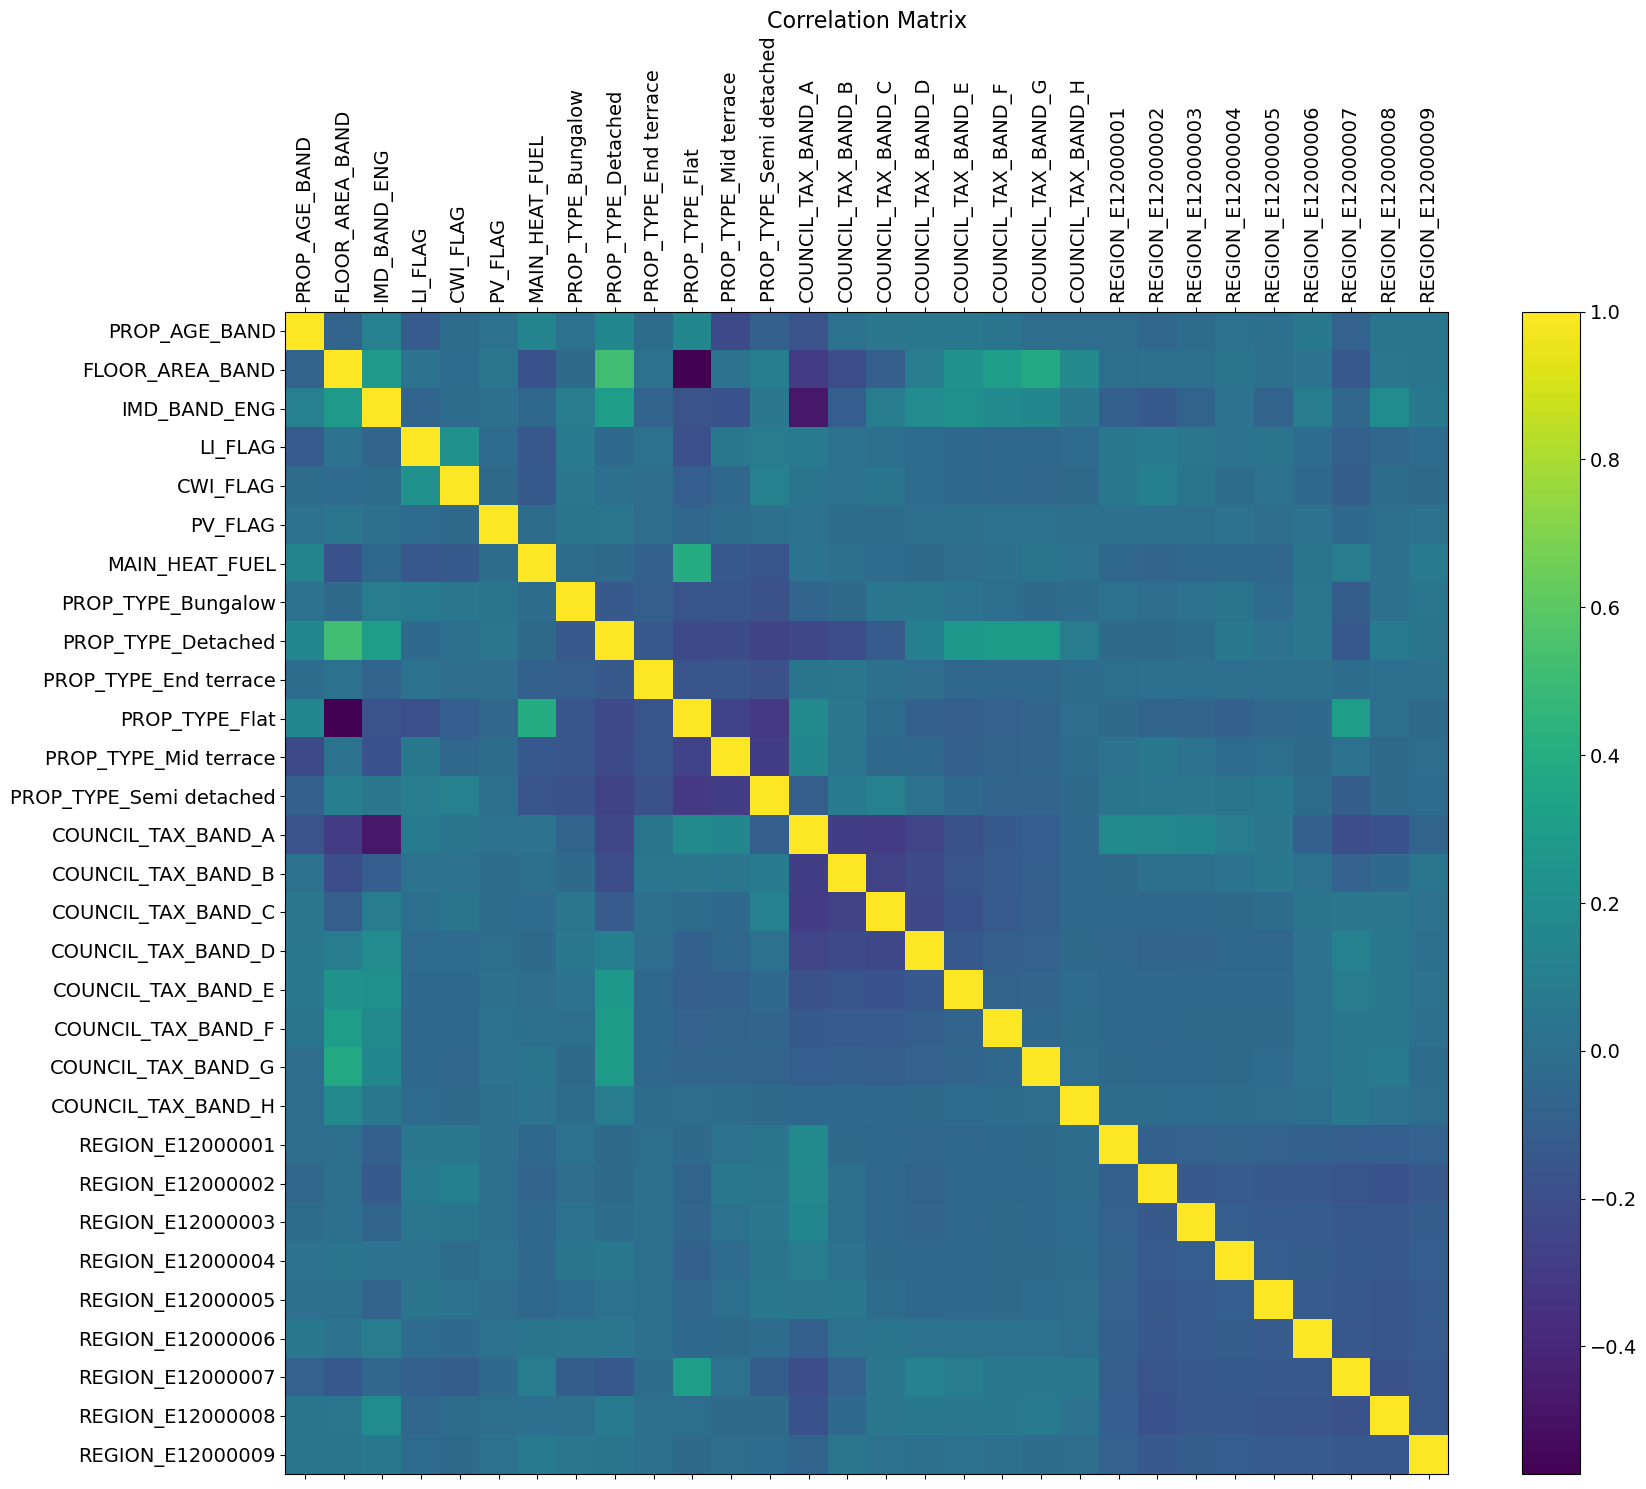

In [34]:
df_filtered_independent = df_filtered_numeric.drop(df_filtered_numeric.columns[7:37], axis=1)

plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df_filtered_independent.corr(), fignum=f.number)
plt.xticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14, rotation=90)
plt.yticks(range(df_filtered_independent.shape[1]), df_filtered_independent.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

## Using VIF to deal with multicollinearity

In [35]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [36]:
# using VIF on the df
df_filtered_VIF = drop_column_using_vif_(df_filtered_numeric.drop(df_filtered_numeric.columns[7:37], axis=1))

# Note that there is a 'while' loop in the drop_column_using_vif_. In each iteration, one variable is dropped.
print("The columns remaining after VIF selection are:")
print(df_filtered_VIF.columns)

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: COUNCIL_TAX_BAND_G


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


Dropping: REGION_E12000004


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/opt/conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Dropping: PROP_TYPE_Bungalow
Dropping: COUNCIL_TAX_BAND_A
The columns remaining after VIF selection are:
Index(['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'IMD_BAND_ENG', 'LI_FLAG',
       'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL', 'PROP_TYPE_Detached',
       'PROP_TYPE_End terrace', 'PROP_TYPE_Flat', 'PROP_TYPE_Mid terrace',
       'PROP_TYPE_Semi detached', 'COUNCIL_TAX_BAND_B', 'COUNCIL_TAX_BAND_C',
       'COUNCIL_TAX_BAND_D', 'COUNCIL_TAX_BAND_E', 'COUNCIL_TAX_BAND_F',
       'COUNCIL_TAX_BAND_H', 'REGION_E12000001', 'REGION_E12000002',
       'REGION_E12000003', 'REGION_E12000005', 'REGION_E12000006',
       'REGION_E12000007', 'REGION_E12000008', 'REGION_E12000009'],
      dtype='object')


## Regression

In [41]:
Gcons2019_comsumption = sm.OLS(endog=df_filtered_numeric[['Gcons2019']], exog=sm.add_constant(df_filtered_VIF)).fit()
Gcons2019_comsumption.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Econs2019   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     317.7
Date:                Fri, 01 Dec 2023   Prob (F-statistic):               0.00
Time:                        12:11:33   Log-Likelihood:            -4.3792e+05
No. Observations:               47335   AIC:                         8.759e+05
Df Residuals:                   47308   BIC:                         8.761e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -46.3513     90.231     -0.514      0.607    -223.205     130.503
PROP_AGE_BAND            -124.5072     12.884     -9.663      0.000    -149.761     -99.253
FLOOR_AREA_BAND           651.5058     19.639     33.175      0.000     613.014     689.998
IMD_BAND_ENG               19.2240      9.863      1.949      0.051      -0.108      38.556
LI_FLAG                  -204.3884     32.648     -6.260      0.000    -268.380    -140.397
CWI_FLAG                  -12.9257     32.480     -0.398      0.691     -76.588      50.736
PV_FLAG                  -318.6686    109.915     -2.899      0.004    -534.103    -103.234
MAIN_HEAT_FUEL           2112.7618     34.026     62.092      0.000    2046.069    2179.454
PROP_TYPE_Detached        285.1482     54.125      5.268      0.000     179.062     391.235
PROP_TYPE_End terrace      10.6731     56.085      0.190      0.849     -99.255     120.601
PROP_TYPE_Flat           -555.9897     54.428    -10.215      0.000    -662.669    -449.311
PROP_TYPE_Mid terrace    -185.6487     49.223     -3.772      0.000    -282.127     -89.170
PROP_TYPE_Semi detached   183.0574     45.944      3.984      0.000      93.007     273.108
COUNCIL_TAX_BAND_B        -82.3922     36.274     -2.271      0.023    -153.489     -11.295
COUNCIL_TAX_BAND_C        -56.0720     37.774     -1.484      0.138    -130.110      17.966
COUNCIL_TAX_BAND_D       -125.7438     43.807     -2.870      0.004    -211.606     -39.882
COUNCIL_TAX_BAND_E        -95.9395     52.937     -1.812      0.070    -199.696       7.817
COUNCIL_TAX_BAND_F        -24.8757     67.874     -0.366      0.714    -157.910     108.159
COUNCIL_TAX_BAND_H       2485.8054    182.903     13.591      0.000    2127.313    2844.297
REGION_E12000001         -259.3687     65.643     -3.951      0.000    -388.030    -130.707
REGION_E12000002          -79.2980     51.035     -1.554      0.120    -179.328      20.732
REGION_E12000003         -172.8285     54.371     -3.179      0.001    -279.396     -66.261
REGION_E12000005           32.1387     53.998      0.595      0.552     -73.699     137.976
REGION_E12000006          250.9013     53.424      4.696      0.000     146.189     355.613
REGION_E12000007          165.8238     56.298      2.945      0.003      55.479     276.169
REGION_E12000008          235.7850     50.512      4.668      0.000     136.780     334.790
REGION_E12000009            9.1383     54.738      0.167      0.867     -98.148     116.425
==============================================================================
Omnibus:                    22896.873   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           189294.322
Skew:                           2.169   Prob(JB):                         0.00
Kurtosi

# Clustering analysis

## Data standardisation

In [55]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = df_filtered.copy()
for c in df_filtered.columns[10:].values:
    data_standardised[c] = mms.fit_transform(df_filtered[c].values.reshape(-1,1))

data_standardised.head()
data_standardised.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PROP_TYPE         47335 non-null  object 
 1   PROP_AGE_BAND     47335 non-null  int64  
 2   FLOOR_AREA_BAND   47335 non-null  int64  
 3   COUNCIL_TAX_BAND  47335 non-null  object 
 4   IMD_BAND_ENG      47335 non-null  float64
 5   REGION            47335 non-null  object 
 6   LI_FLAG           47335 non-null  int64  
 7   CWI_FLAG          47335 non-null  int64  
 8   PV_FLAG           47335 non-null  int64  
 9   MAIN_HEAT_FUEL    47335 non-null  int64  
 10  Gcons2019         47335 non-null  float64
 11  Gcons2018         47335 non-null  float64
 12  Gcons2017         47335 non-null  float64
 13  Gcons2016         47335 non-null  float64
 14  Gcons2015         47335 non-null  float64
 15  Gcons2014         47335 non-null  float64
 16  Gcons2013         47335 non-null  float64
 17

## Kmeans clustering

In [68]:
# data_standardised_cons = data_standardised.iloc[:,10:]
data_standardised_cons = data_standardised.loc[:,['Gcons2019','Econs2019']]

# we fix the random_state so that the kmeans result is reproducible
num_clusters = 2
random_state_seed = 100

kmeans_output = sklc.KMeans(n_clusters=num_clusters, random_state=random_state_seed).fit(data_standardised_cons)

# Sanity check
print(kmeans_output)                                              

/opt/conda/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=100)


In [69]:
# This line creates a list giving the final cluster number of each point:
clustering_ids_kmeans = kmeans_output.labels_

# You can print the clustering IDs to get an ordered list of labels
print(clustering_ids_kmeans)

# we will combine the clustering IDs to the dataframe
data_cluster = data_standardised_cons.assign(cluster_id = clustering_ids_kmeans)

#Have a look at the result:
data_cluster.info()

[0 0 0 ... 0 1 1]
<class 'pandas.core.frame.DataFrame'>
Index: 47335 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gcons2019   47335 non-null  float64
 1   Econs2019   47335 non-null  float64
 2   cluster_id  47335 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 1.3 MB


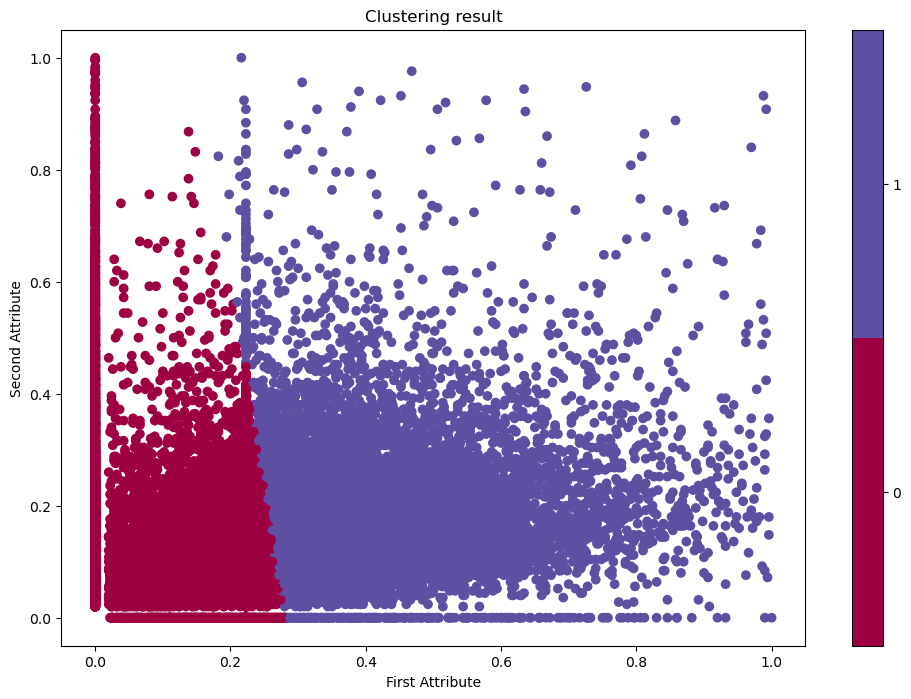

In [70]:
fig, ax = plt.subplots(figsize=(12,8))

# number of clusters
n_clusters = data_cluster.cluster_id.nunique()

# get discrete colormap
cmap = plt.get_cmap('Spectral', n_clusters)

# scatter points
scatter = ax.scatter(data_cluster.Gcons2019, data_cluster.Econs2019, c=data_cluster.cluster_id, cmap=cmap)
ax.set_xlabel('First Attribute')
ax.set_ylabel('Second Attribute')
ax.set_title('Clustering result')

# add colorbar
cbar = plt.colorbar(scatter)

# set ticks locations (not very elegant, but it works):
# - shift by 0.5
# - scale so that the last value is at the center of the last color
tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
cbar.set_ticks(tick_locs)

# set tick labels (as before)
cbar.set_ticklabels(np.arange(n_clusters))